# Курсовая работа по дисциплине “Технологии анализа данных и машинное обучение“

## Тема курсовой работы

Решение задач кластеризации тестов с помощью методов глубокого обучения

## Цель работы

Продемонстрировать владение основными навыками обучения и применения моделей глубокого обучения, владение основными инструментальными средствами библиотек языка программирования Python для глубокого обучения, в том числе фреймворком для глубокого обучения PyTorch, методами сбора и подготовки набора данных, анализа качества обучения модели глубокого обучения, умение делать выводы из проведенного анализа.


In [185]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.cluster import KMeans
import re

## Выполнение работы

Считываем данные из Excel-файла

In [173]:
df = pd.read_excel('texts.xlsx')
df.head()

,text,label
0,"Полина составляет 4-буквенные коды из букв П, ...",0
1,"Петя составляет 6-буквенные коды из букв П, Е,...",0
2,"Иван составляет 5-буквенные коды из букв И, В,...",0
3,"Света составляет 5-буквенные коды из букв С, В...",0
4,Для передачи сообщений используются 5-буквенны...,0


Проводим предварительный анализ

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    200 non-null    object
 1   label   200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [175]:
df.label.unique()

array([0, 1, 2, 3, 4, 5])

*   text - текст тестового вопроса
*   label - метка класса: 0 – информатика, 1 – литература, 2 – биология, 3 – математика, 4 – русский язык, 5 - география



Для удобства представим данные в виде списков

In [176]:
texts = df['text'].tolist()
labels = df['label'].tolist()

Создадим Embeddings для дальнейшей векторизации тестов и саму модель, которую мы будем обучать, модель будет базироваться на GRU

In [177]:
class MyWordEmbeddings(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(MyWordEmbeddings, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)

    def forward(self, x):
        x = self.embedding(x)
        return x


class RNNClustering(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_clusters):
        super(RNNClustering, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_clusters)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.linear(out[:, -1, :])
        return out

Создадим словарь, который будет использоваться для преобразования слов в числовые индексы. Это позволит использовать их в качестве входных данных для нашей модели.

In [178]:
word2idx = {}
idx = 0
tokenized_texts = []

for text in texts:
    text = re.sub(r'[^а-яА-Я.,!?]', ' ', text.lower())
    tokens = text.split()
    tokenized_texts.append(tokens)
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

vocab_size = len(word2idx)

max_len = max([len(tokens) for tokens in tokenized_texts])
X = torch.zeros(len(tokenized_texts), max_len, dtype=torch.long)

for i, tokens in enumerate(tokenized_texts):
    for j, token in enumerate(tokens):
        X[i, j] = word2idx[token]

In [179]:
for key, value in list(word2idx.items())[:6]:
    print(f"'{key}': {value},")

'полина': 0,
'составляет': 1,
'буквенные': 2,
'коды': 3,
'из': 4,
'букв': 5,


Создадим модель

In [180]:
embedding_size = 64
hidden_size = 64
num_layers = 3
num_clusters = len(set(labels))

word_embeddings = MyWordEmbeddings(vocab_size, embedding_size)
model = RNNClustering(embedding_size, hidden_size, num_layers, num_clusters)

Обучим модель

In [181]:
batch_size = 4
lr = 0.01
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=lr)
ce_loss = nn.CrossEntropyLoss()

dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

f_one = nn

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs in dataloader:
        optimizer.zero_grad()
        embeddings = word_embeddings(inputs[0])
        outputs = model(embeddings)
        loss = ce_loss(outputs, outputs.max(1)[1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch {}".format(epoch + 1), "Loss = {:.4f}".format(running_loss))

Epoch 1 Loss = 2.6810
Epoch 2 Loss = 0.0010
Epoch 3 Loss = 0.0009
Epoch 4 Loss = 0.0009
Epoch 5 Loss = 0.0008
Epoch 6 Loss = 0.0008
Epoch 7 Loss = 0.0007
Epoch 8 Loss = 0.0007
Epoch 9 Loss = 0.0006
Epoch 10 Loss = 0.0006


Оценим модель с помощью метрик

In [186]:
embeddings = word_embeddings(X)
with torch.no_grad():
    outputs = model(embeddings).numpy()
    pred_labels = KMeans(n_clusters=num_clusters, n_init = 10).fit_predict(outputs)

ari = adjusted_rand_score(labels, pred_labels)
nmi = normalized_mutual_info_score(labels, pred_labels)
f1_score = metrics.f1_score(labels, pred_labels, average='weighted')
fmi = fowlkes_mallows_score(labels, pred_labels)

print("Adjusted Rand index: {:.2f}".format(ari))
print("F1 score: {:.2f}".format(f1_score))
print("Normalized Mutual Information: {:.2f}".format(nmi))
print("Fowlkes-Mallows index: {:.2f}".format(fmi))

Adjusted Rand index: 0.08
F1 score: 0.19
Normalized Mutual Information: 0.22
Fowlkes-Mallows index: 0.32


Визуализация кластеров

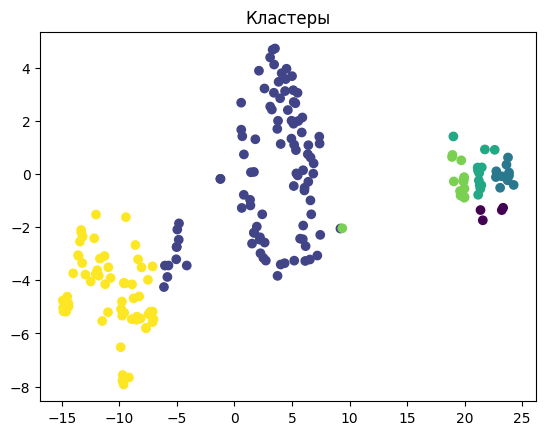

In [183]:
tsne = TSNE(n_components=2, perplexity=len(outputs)/num_clusters)
embeddings_tsne = tsne.fit_transform(outputs)

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=pred_labels)
plt.title("Кластеры")
plt.show()

Визуализация определения оптимального количества классов с помощью метода локтя

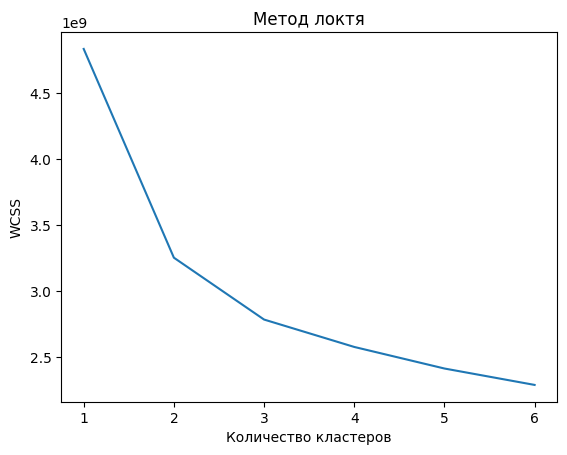

In [184]:
k_max = len(set(labels))

wcss = []

for k in range(1, k_max+1):
    kmeans = KMeans(n_clusters=k, n_init = 10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, k_max+1), wcss)
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()